# Evaluating Clustering Quality on Wine Dataset
## Silhouette vs Calinski–Harabasz vs DBCV

The notebook demonstrates how clustering models were evaluated using three metrics:
- **Silhouette**
- **Calinski–Harabasz**
- **DBCV**

The Wine dataset was visualized in 2D using PCA to illustrate the cluster structure.


## Imports and Setup

Necessary Python libraries were imported for data manipulation, clustering, evaluation metrics, and visualization. Plotting style was configured for clarity.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.1)

## Load the Wine Dataset

The Wine dataset for clustering was obtained from Kaggle:

**Dataset:** [Wine Dataset for Clustering by Harry Wang](https://www.kaggle.com/datasets/harrywang/wine-dataset-for-clustering)

This dataset contains 13 numeric features describing different wine samples.
It has been used to demonstrate clustering evaluation techniques.

The file `wine-clustering.csv` should be downloaded locally and the path set correctly in the code.


In [2]:
wine_path = 'wine-clustering.csv'
data = pd.read_csv(wine_path)
data.head()


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Preprocessing

Numeric features were selected and scaled. Scaling ensured that all features contributed equally to clustering and PCA computations.

In [3]:
features = data.select_dtypes(include=[np.number]).columns.tolist()
X = data[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## PCA: Visualizing 13D Data in 2D

The Wine dataset has 13 numeric features. Direct visualization of 13D data is not possible, so Principal Component Analysis (PCA) was applied.


Explained variance ratio:
PC1: 36.20%
PC2: 19.21%
Total variance captured by first 2 PCs: 55.41%


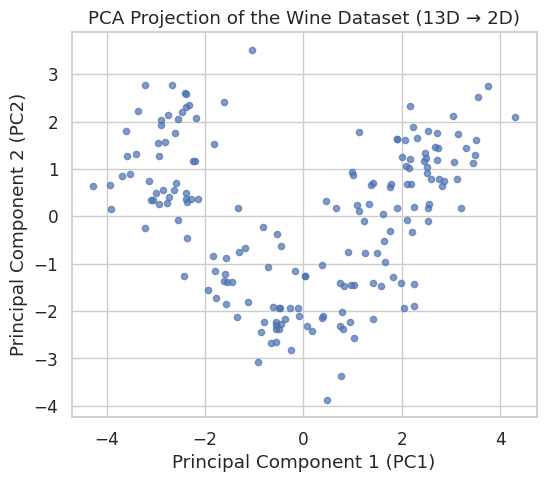

In [4]:
pca = PCA(n_components=2, random_state=42)
X_pca2 = pca.fit_transform(X_scaled)

print("Explained variance ratio:")
print(f'PC1: {pca.explained_variance_ratio_[0]*100:.2f}%')
print(f'PC2: {pca.explained_variance_ratio_[1]*100:.2f}%')
print(f'Total variance captured by first 2 PCs: {np.sum(pca.explained_variance_ratio_[:2])*100:.2f}%')

plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=20, alpha=0.7)
plt.title('PCA Projection of the Wine Dataset (13D → 2D)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()


### What is PCA doing?

Principal Component Analysis (PCA) looks at how the data **varies** across all 13 features and finds new axes — called **principal components** — that capture the **most variance**.

- The **Variance** measures how much the data “spreads” along a direction.
- PCA chooses the direction where this spread (variance) is **maximum** → that’s **PC1**.
- Then it finds another direction, **PC2**, orthogonal to PC1, that captures the next largest variance.

When we project our 13-dimensional points onto these two axes (PC1, PC2), we get the **most informative 2D view** of the dataset possible.

So:
- **X-axis → PC1:** most variation in the data
- **Y-axis → PC2:** second most variation
- The scatterplot shows each sample projected on these two directions.

This is why PCA is widely used for **visualizing high-dimensional datasets** — it gives a faithful 2D summary while preserving most of the structure.


## Clustering Evaluation Functions

We define functions to compute the three evaluation metrics:

- **Silhouette Score**: Measures how close each point is to points in its own cluster compared to points in other clusters. Higher is better.
- **Calinski–Harabasz Index**: Ratio of between-cluster variance to within-cluster variance. Higher is better.
- **DBCV (simplified)**: Measures density-based cluster separation. Higher is better.

We use a simplified DBCV function for demonstration.


## Silhouette Score

The Silhouette Score measures how similar a sample is to its own cluster compared to other clusters.

**Formula:**

$$
s = \frac{b - a}{\max(a, b)}
$$

Where:
- a = average distance to points in the same cluster
- b = average distance to points in the nearest different cluster

**Range:** -1 to 1
- Close to 1 → well-clustered
- Close to 0 → overlapping clusters
- Negative → probably misclassified

**Notes:** Works best for globular clusters, such as those produced by KMeans.


In [5]:
def safe_silhouette(X, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) <= 1:
        return np.nan
    return silhouette_score(X[mask], labels[mask])


## Calinski–Harabasz Index (CH)

The Calinski–Harabasz Index measures the ratio of between-cluster dispersion to within-cluster dispersion.

**Formula:**

$$
CH = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \times \frac{n - k}{k - 1}
$$

Where:
- Tr(Bk) = trace of the between-cluster dispersion matrix
- Tr(Wk) = trace of the within-cluster dispersion matrix
- n = number of samples
- k = number of clusters

**Interpretation:**
- Higher CH → better separation
- Fast to compute
- Works best for globular clusters; less meaningful for irregular shapes


In [6]:
def safe_calinski(X, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) <= 1:
        return np.nan
    return calinski_harabasz_score(X[mask], labels[mask])


## DBCV (Density-Based Clustering Validation)

DBCV measures density separation between clusters.

A simplified version is used here for demonstration. Conceptually:

- $D$ = pairwise distance matrix
- $C_i$ = cluster $i$
- $intra(C_i)$ = average intra-cluster distance
- $inter(C_i)$ = average distance to points not in $C_i$

Then a simplified DBCV score is:

$$
DBCV = \frac{\text{mean}(inter) - \text{mean}(intra)}{\text{mean}(inter)}
$$

**Range:** 0 to 1 (higher is better)
- Useful for non-globular clusters like moons or circles
- Highlights density-based separation, suitable for DBSCAN


In [7]:
def simple_dbcv(X, labels):
    unique_labels = [l for l in np.unique(labels) if l != -1]
    if len(unique_labels) <= 1:
        return np.nan
    D = pairwise_distances(X)
    intra_dists, inter_dists = [], []
    for c in unique_labels:
        idx = labels == c
        if np.sum(idx) < 2:
            continue
        intra = D[np.ix_(idx, idx)]
        inter = D[np.ix_(idx, ~idx)]
        intra_dists.append(np.mean(intra))
        inter_dists.append(np.mean(inter))
    intra_mean = np.mean(intra_dists)
    inter_mean = np.mean(inter_dists)
    return (inter_mean - intra_mean) / inter_mean

def safe_dbcv(X, labels):
    try:
        return simple_dbcv(X, labels)
    except:
        return np.nan


## Comprehensive Evaluation

All three metrics were applied across multiple clustering models:

- **KMeans**: k = 2 to 8
- **DBSCAN**: eps = 0.3 to 2.0

A summary table was generated showing Silhouette, Calinski–Harabasz, and DBCV scores for each model.


In [9]:
results = []

# KMeans
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    labels = km.labels_
    results.append({
        'model': f'KMeans_k{k}',
        'algo': 'KMeans',
        'n_clusters': k,
        'labels': labels,
        'silhouette': safe_silhouette(X_scaled, labels),
        'calinski': safe_calinski(X_scaled, labels),
        'dbcv': safe_dbcv(X_scaled, labels)
    })

# DBSCAN
eps_values = np.linspace(0.3, 2.0, 8)
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5).fit(X_scaled)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    results.append({
        'model': f'DBSCAN_eps{eps:.2f}',
        'algo': 'DBSCAN',
        'n_clusters': n_clusters,
        'labels': labels,
        'silhouette': safe_silhouette(X_scaled, labels),
        'calinski': safe_calinski(X_scaled, labels),
        'dbcv': safe_dbcv(X_scaled, labels)
    })

summary = pd.DataFrame(results)
summary = summary.sort_values(['algo','n_clusters']).reset_index(drop=True)
summary.head()


,model,algo,n_clusters,labels,silhouette,calinski,dbcv
0,DBSCAN_eps0.30,DBSCAN,0,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",NaN,NaN,NaN
1,DBSCAN_eps0.54,DBSCAN,0,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",NaN,NaN,NaN
2,DBSCAN_eps0.79,DBSCAN,0,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",NaN,NaN,NaN
3,DBSCAN_eps1.03,DBSCAN,0,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",NaN,NaN,NaN
4,DBSCAN_eps1.27,DBSCAN,0,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",NaN,NaN,NaN


## Visualize Metric Scores

Bar plots were created to compare Silhouette, Calinski–Harabasz, and DBCV scores across all clustering models.


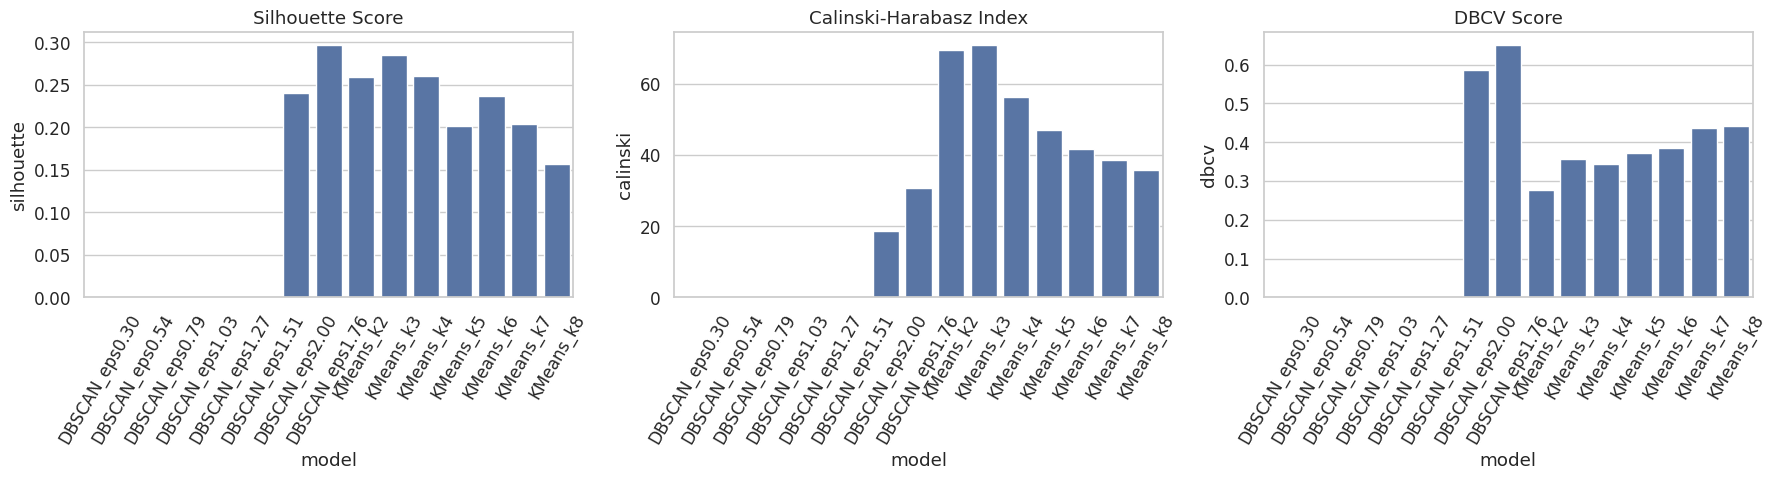

In [10]:
fig, axs = plt.subplots(1,3, figsize=(18,5))

sns.barplot(data=summary, x='model', y='silhouette', ax=axs[0])
axs[0].set_title('Silhouette Score')
axs[0].tick_params(axis='x', rotation=60)

sns.barplot(data=summary, x='model', y='calinski', ax=axs[1])
axs[1].set_title('Calinski-Harabasz Index')
axs[1].tick_params(axis='x', rotation=60)

sns.barplot(data=summary, x='model', y='dbcv', ax=axs[2])
axs[2].set_title('DBCV Score')
axs[2].tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()


## Why Some Metric Values Are Zero or NaN

For some DBSCAN runs (e.g., `DBSCAN_eps0.30` and later), certain evaluation metrics show 0 or NaN. This occurs because:

1. **DBSCAN may find no clusters** at very small `eps` values.
   - `eps` is the neighborhood radius.
   - If `eps` is too small, all points are considered **noise** (`label = -1`).
   - In this case, metrics like Silhouette or Calinski–Harabasz cannot be computed, because there are **no valid clusters**.

2. **Very few clusters**
   - If DBSCAN produces only 1 cluster or all points are in noise, these metrics are undefined.
   - In the code, the function `safe_silhouette` and `safe_calinski` returns `np.nan` in these cases.

3. **Density-based behavior**
   - DBSCAN adapts to data density:
     - Small `eps` → mostly noise, no clusters → metrics undefined
     - Large `eps` → clusters merge → metrics may drop because clusters become too big or overlap
   - Only a **medium range of `eps`** produces meaningful clusters and valid metric values.


Metrics are not zero by error — they indicate that **DBSCAN did not produce valid clusters** for that parameter.
This highlights the importance of **choosing appropriate hyperparameters** for density-based clustering.


## Rank Models by Metric

Each clustering model was ranked according to each evaluation metric.
Higher values indicate better clustering.


In [13]:
for col in ['silhouette','calinski','dbcv']:
    summary[col + '_rank'] = summary[col].rank(method='min', ascending=False, na_option='bottom').astype(int)

summary.head()


,model,algo,n_clusters,labels,silhouette,calinski,dbcv,silhouette_rank,calinski_rank,dbcv_rank
0,DBSCAN_eps0.30,DBSCAN,0,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",NaN,NaN,NaN,10,10,10
1,DBSCAN_eps0.54,DBSCAN,0,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",NaN,NaN,NaN,10,10,10
2,DBSCAN_eps0.79,DBSCAN,0,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",NaN,NaN,NaN,10,10,10
3,DBSCAN_eps1.03,DBSCAN,0,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",NaN,NaN,NaN,10,10,10
4,DBSCAN_eps1.27,DBSCAN,0,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",NaN,NaN,NaN,10,10,10


## Visualize Top Models on PCA

The top-ranked clustering models for each metric were visualized on the 2D PCA plane.
Clusters were colored by label, and noise points detected by DBSCAN were shown in black.


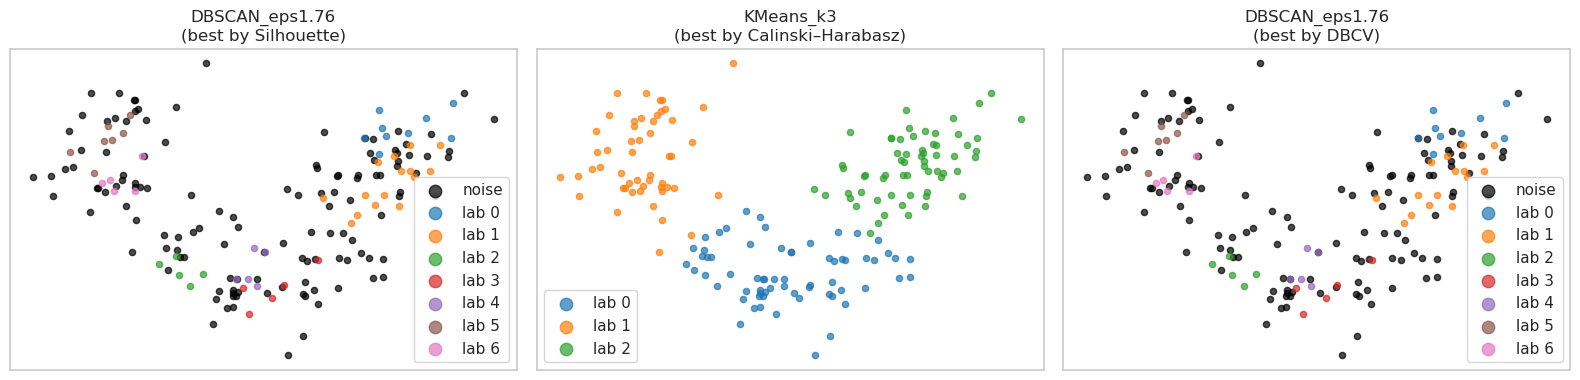

In [15]:
top_sil = summary.sort_values('silhouette_rank').iloc[0]['model']
top_cal = summary.sort_values('calinski_rank').iloc[0]['model']
top_dbcv = summary.sort_values('dbcv_rank').iloc[0]['model']
selected = [top_sil, top_cal, top_dbcv]
metrics = ['Silhouette', 'Calinski–Harabasz', 'DBCV']

plt.figure(figsize=(16,4))
for i, m in enumerate(selected):
    labels = summary.loc[summary['model']==m, 'labels'].values[0]
    plt.subplot(1,3,i+1)
    cmap = plt.cm.get_cmap('tab10')
    unique = np.unique(labels)
    for lab in unique:
        mask = labels == lab
        color = 'black' if lab==-1 else cmap(int(lab)%10)
        plt.scatter(X_pca2[mask,0], X_pca2[mask,1], s=20, color=color, label=f'lab {lab}' if lab!=-1 else 'noise', alpha=0.7)
    plt.title(f'{m}\n(best by {metrics[i]})', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc='best', markerscale=2, fontsize='small')
plt.tight_layout()
plt.show()

